In [1]:
import numpy as np
import pandas as pd
import signac
import json
from typing import Tuple
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.estimators import MBAR
import matplotlib.pyplot as plt

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
temperature = 298
with open("signac_project_document.json") as pipe:
    data = json.load(pipe)["free_energies"]

In [3]:
df = pd.DataFrame(data)
# kt_to_kj_mol = 2.479
# df["f_mean"] *= kt_to_kj_mol
# df["f_std"] *= kt_to_kj_mol
df.sort_values(by="solvent_name", ignore_index=True)

,solvent_name,solute_name,f_mean,f_std
0,OCO,"P6 C3 N1,0-1 1-2 0-2",12.809758,0.046527
1,W,"P6 C3 N1,0-1 1-2 0-2",10.919100,0.053222


In [4]:
project = signac.get_project()
project

,sp.solvent_name,sp.solute_name,sp.lambda_state,doc.system_gro,doc.system_top,doc.solute_name,doc.solute_itp,doc.system_prepared,doc.alchemical_xvg,doc.alchemical_log,doc.solute_top,doc.solute_gro,doc.solvent_top,doc.solvent_name,doc.solvent_gro,doc.solute_solvent_top,doc.solute_solvent_gro
409e031a357e690e3a9bfb08ad8dc62b,W,"P6 C3 N1,0-1 1-2 0-2",4,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-4.xvg,fep_run-4.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a055dff099fa0a47ac6e63f44229c490,OCO,"P6 C3 N1,0-1 1-2 0-2",10,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-10.xvg,fep_run-10.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c48fdbe0782ee3470119f42b38df5ccf,OCO,"P6 C3 N1,0-1 1-2 0-2",4,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-4.xvg,fep_run-4.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3554d989f726bc534b83b119e469960f,W,"P6 C3 N1,0-1 1-2 0-2",7,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-7.xvg,fep_run-7.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242eeeb1deb77eed29a070201f8e9b5b,W,"P6 C3 N1,0-1 1-2 0-2",2,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-2.xvg,fep_run-2.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13b4b2684186650a1a795143f2860024,OCO,"P6 C3 N1,0-1 1-2 0-2",1,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-1.xvg,fep_run-1.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266290c36b2b080b8bace7eed7eaa1a2,W,"P6 C3 N1,0-1 1-2 0-2",10,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-10.xvg,fep_run-10.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c8e2e6ae776dc725fa3cbec83991a1a1,OCO,"P6 C3 N1,0-1 1-2 0-2",5,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-5.xvg,fep_run-5.log,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9d5b30dbca5285438906215d1a0676e2,OCO,"P6 C3 N1,0-1 1-2 0-2",0,solute_solvent_equ.gro,solute_solvent.top,P6C3N1,solute.itp,True,fep_run-0.xvg,fep_run-0.log,solute.top,solute_min.gro,solvent_gen_box.top,OCO,solvent_prod.gro,solute_solvent.top,solute_solvent_equ.gro


In [5]:
def compute_free_energy_for_statepoint(statepoint: dict) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    jobs = project.find_jobs(statepoint)
    xvg_files = [
        job.fn(f"fep_run-{job.statepoint['lambda_state']}.xvg")
        for job in jobs
        if 'lambda_state' in job.statepoint
    ]
    u_nk_list = [extract_u_nk(f, T=temperature) for f in xvg_files]
    u_nk_combined = pd.concat(u_nk_list)
    mbar = MBAR().fit(u_nk_combined)
    # Extracting free energy differences between the first and last state
    delta_f_values = mbar.delta_f_.iloc[0, :].values
    d_delta_f_values = mbar.d_delta_f_.iloc[0, :].values
    return delta_f_values, d_delta_f_values, mbar.delta_f_.columns.values

In [8]:
delta_f_w, d_delta_f_w, states_w = compute_free_energy_for_statepoint({'solvent_name': 'W', 'solute_name': 'P6 C3 N1,0-1 1-2 0-2'})
delta_f_oco, d_delta_f_oco, states_oco = compute_free_energy_for_statepoint({'solvent_name': 'OCO', 'solute_name': 'P6 C3 N1,0-1 1-2 0-2'})


******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************

I0000 00:00:1703854469.817549   99415 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


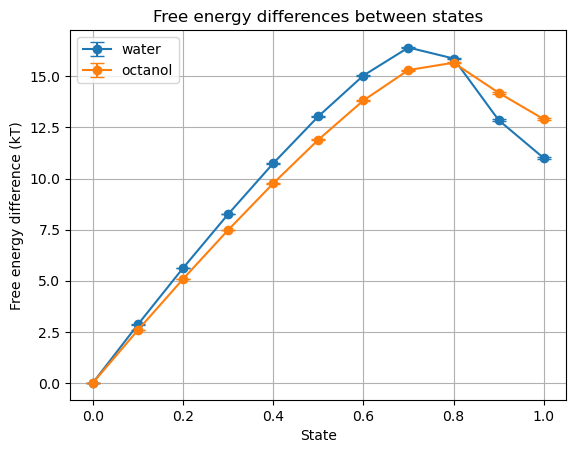

In [9]:
# Plotting free energy differences
plt.errorbar(
    states_w, delta_f_w, yerr=d_delta_f_w, marker='o', linestyle='-', capsize=5, label="water"
)
plt.errorbar(
    states_oco, delta_f_oco, yerr=d_delta_f_oco, marker='o', linestyle='-', capsize=5, label="octanol"
)

plt.xlabel('State')
plt.ylabel('Free energy difference (kT)')
plt.title('Free energy differences between states')
plt.legend()
plt.grid()

# Display the plot
plt.show()